# 02 - EDA
___

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from nltk.corpus import stopwords
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 35

___

In [2]:
# read in our card files
df = pd.read_csv('../Data/cards_cleaned.csv')
df.head()

,name,layout,colors,color_identity,mana_cost,cmc,type_line,card_type,super_type,sub_type,oracle_text,oracle_text_token,legalities,rarity,power,toughness,loyalty,activated_ability,triggered_ability,oracle_text_back,oracle_text_back_token,colors_back,power_back,toughness_back,loyalty_back,card_type_back,super_type_back,sub_type_back,mana_cost_back,scryfall_uri
0,Static Orb,normal,[],[],{3},3.0,Artifact,Artifact,NONE,NONE,"As long as Static Orb is untapped, players can...",as long as static orb is untapped players can'...,legacy vintage commander duel,rare,NONE,NONE,NONE,0.0,0.0,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,https://scryfall.com/card/7ed/319/static-orb?u...
1,Sensory Deprivation,normal,['U'],['U'],{U},1.0,Enchantment — Aura,Enchantment,NONE,Aura,Enchant creature Enchanted creature gets -3/-0.,enchant creature enchanted creature gets -3/-0,pioneer modern legacy pauper vintage penny com...,common,NONE,NONE,NONE,0.0,0.0,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,https://scryfall.com/card/m14/71/sensory-depri...
2,Road of Return,normal,['G'],['G'],{G}{G},2.0,Sorcery,Sorcery,NONE,NONE,Choose one — • Return target permanent card fr...,choose one return target permanent card from y...,legacy vintage commander duel,rare,NONE,NONE,NONE,0.0,0.0,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,https://scryfall.com/card/c19/34/road-of-retur...
3,Storm Crow,normal,['U'],['U'],{1}{U},2.0,Creature — Bird,Creature,NONE,Bird,Flying (This creature can't be blocked except ...,flying this creature can't be blocked except b...,modern legacy pauper vintage penny commander duel,common,1,2,NONE,0.0,0.0,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,https://scryfall.com/card/9ed/100/storm-crow?u...
4,Walking Sponge,normal,['U'],['U'],{1}{U},2.0,Creature — Sponge,Creature,NONE,Sponge,{T}: Target creature loses your choice of flyi...,{t} target creature loses your choice of flyin...,legacy vintage penny commander duel,uncommon,1,1,NONE,1.0,0.0,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,https://scryfall.com/card/ulg/47/walking-spong...


In [3]:
df.shape

(20053, 30)

In [4]:
df.dtypes

name                       object
layout                     object
colors                     object
color_identity             object
mana_cost                  object
cmc                       float64
type_line                  object
card_type                  object
super_type                 object
sub_type                   object
oracle_text                object
oracle_text_token          object
legalities                 object
rarity                     object
power                      object
toughness                  object
loyalty                    object
activated_ability         float64
triggered_ability         float64
oracle_text_back           object
oracle_text_back_token     object
colors_back                object
power_back                 object
toughness_back             object
loyalty_back               object
card_type_back             object
super_type_back            object
sub_type_back              object
mana_cost_back             object
scryfall_uri  

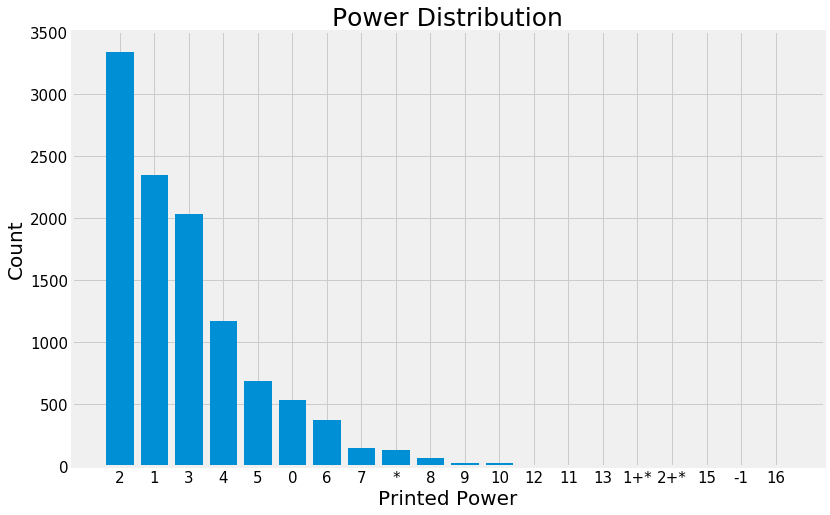

In [5]:
# get the power of the front and back half of each card
power = list(df.loc[df['power'] != 'NONE']['power'].values) + list(df.loc[df['power_back'] != 'NONE']['power_back'].values)

plt.figure(figsize=(12,8))
plt.bar(x = pd.DataFrame(power)[0].value_counts().index, 
        height = pd.DataFrame(power)[0].value_counts(),
        )
plt.ylabel('Count', fontsize=20)
plt.yticks(size=15)
plt.xlabel('Printed Power', fontsize=20)
plt.xticks(size=15)
plt.title(label='Power Distribution', fontsize=25);

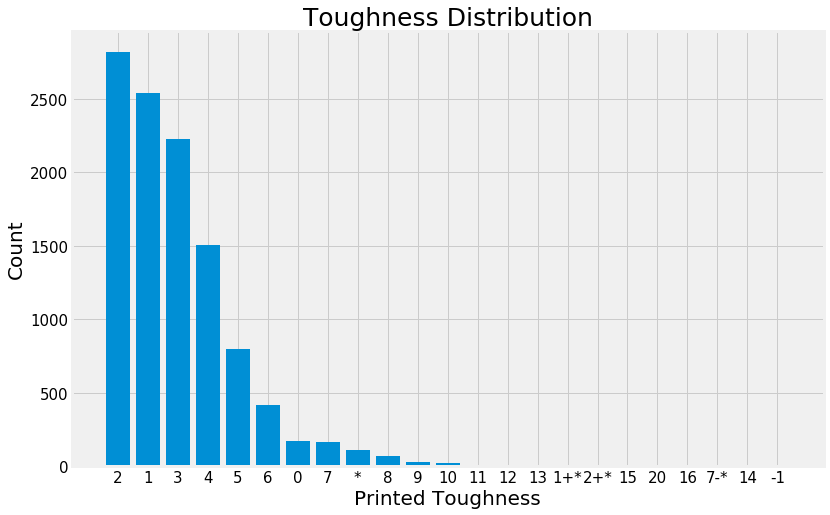

In [6]:
# get toughness from the front and back half of each card
toughness = list(df.loc[df['toughness'] != 'NONE']['toughness'].values) + list(df.loc[df['toughness_back'] != 'NONE']['toughness_back'].values)

plt.figure(figsize=(12,8))
plt.bar(x = pd.DataFrame(toughness)[0].value_counts().index,
        height= pd.DataFrame(toughness)[0].value_counts())

plt.ylabel('Count', fontsize=20)
plt.yticks(size=15)
plt.xlabel('Printed Toughness', fontsize=20)
plt.xticks(size=15)
plt.title(label='Toughness Distribution', fontsize=25);

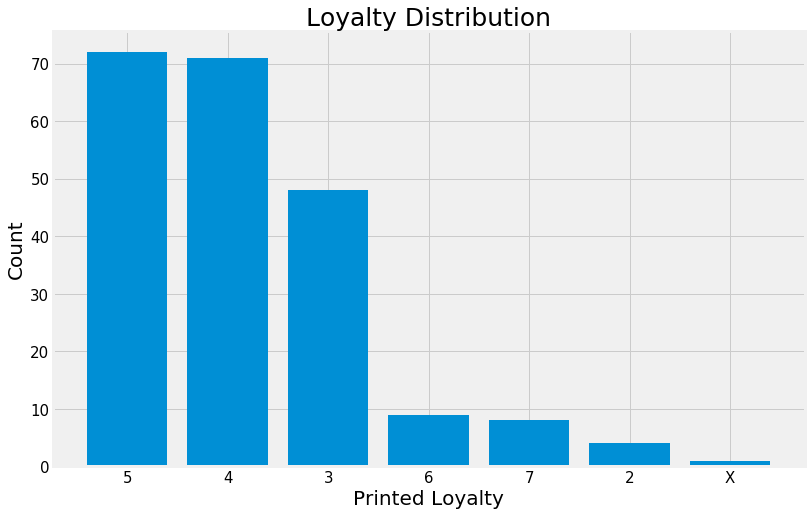

In [7]:
# get the loyalty from both front and back half of each card
loyalty = list(df.loc[df['loyalty'] != 'NONE']['loyalty'].values) + list(df.loc[df['loyalty_back'] != 'NONE']['loyalty_back'].values)

plt.figure(figsize=(12,8))
plt.bar(x = pd.DataFrame(loyalty)[0].value_counts().index,
        height = pd.DataFrame(loyalty)[0].value_counts())
plt.ylabel('Count', fontsize=20)
plt.yticks(size=15)
plt.xlabel('Printed Loyalty', fontsize=20)
plt.xticks(size=15)
plt.title(label='Loyalty Distribution', fontsize=25);

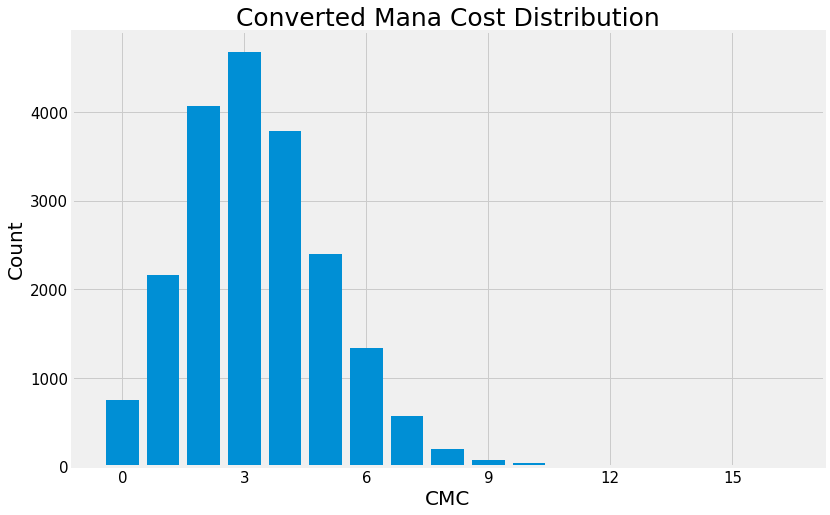

In [8]:
plt.figure(figsize=(12,8))
plt.bar(x = df['cmc'].value_counts().index, height=df['cmc'].value_counts());
plt.xticks(ticks=range(0,16,3));
plt.ylabel('Count', fontsize=20)
plt.yticks(size=15)
plt.xlabel('CMC', fontsize=20)
plt.xticks(size=15)
plt.title(label='Converted Mana Cost Distribution', fontsize=25);

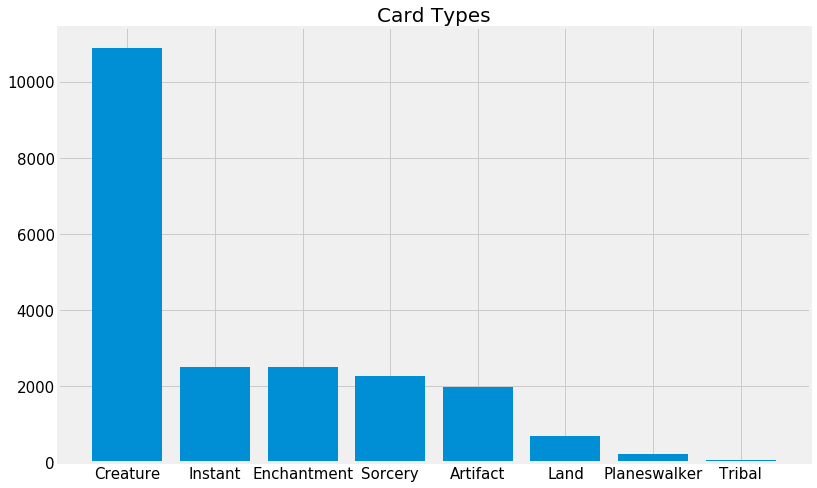

In [9]:
card_types = {
    'Creature' : 0,
    'Instant' : 0,
    'Enchantment' : 0,
    'Sorcery' : 0,
    'Artifact' : 0,
    'Land' : 0,
    'Planeswalker' : 0,
    'Tribal' : 0
}

# front half of cards
for card in df['card_type'].values:
    for ctype in card_types:
        if ctype in card:
            card_types[ctype] += 1
            
# back half of cards
for card in df.loc[df['card_type_back'] != 'NONE']['card_type_back'].values:
    for ctype in card_types:
        if ctype in card:
            card_types[ctype] += 1

plt.figure(figsize=(12,8))
plt.bar(x=list(card_types.keys()), height=list(card_types.values()))
plt.yticks(fontsize=15)
plt.title(label='Card Types', fontsize=20)
plt.xticks(fontsize=15);

___

## Count Vectorizer

In [10]:
def top_words(df, card_type, ng=(1,1), stops=['none']):
    # top words used in oracle text for only types (minus stop words)

    warnings.filterwarnings(action='error') # turning off errors for this cell

    # combine both front and back halves of the oracle text
    X = df['oracle_text_token'] + " " + df['oracle_text_back_token']

    # Initialize the CountVectorizer
    cvec = CountVectorizer(stop_words=stops,
                          min_df=2,
                          max_df=.98,
                          ngram_range=ng,
                          token_pattern="[a-zA-Z{}+'0-9-/−]+") # This RegEx string keeps together certain key magic terms

    # fit to our data
    X = cvec.fit_transform(X);

    # create a df of all the words
    oracle_df = pd.DataFrame(X.toarray(), columns=cvec.get_feature_names())

    warnings.filterwarnings(action='default') # turning erros back on

    # get the top 20 words
    top_words = oracle_df.sum().sort_values(ascending=True).tail(20)

    # plot our top words
    plt.figure(figsize=(12,8))
    plt.barh(y = top_words.index, width=top_words.values);

    plt.ylabel('Words', fontsize=20)
    plt.yticks(size=15)

    plt.xlabel('Count', fontsize=20)
    plt.xticks(size=15)

    plt.title(label=f'Top {card_type} Oracle Words', fontsize=25)
    plt.tight_layout();

In [11]:
# use nltk's stop words but add the word 'none'
stops = stopwords.words()
stops += ['none']

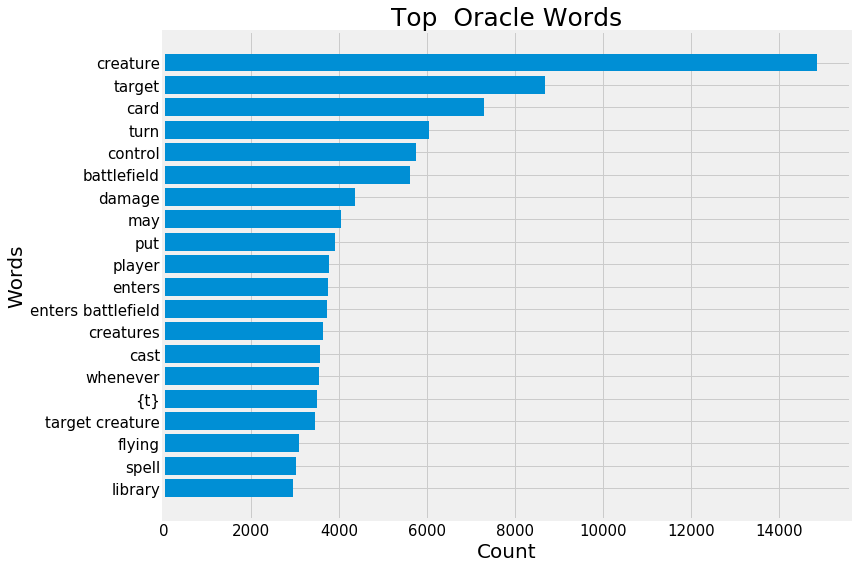

In [12]:
top_words(df, '', ng=(1,6), stops=stops)

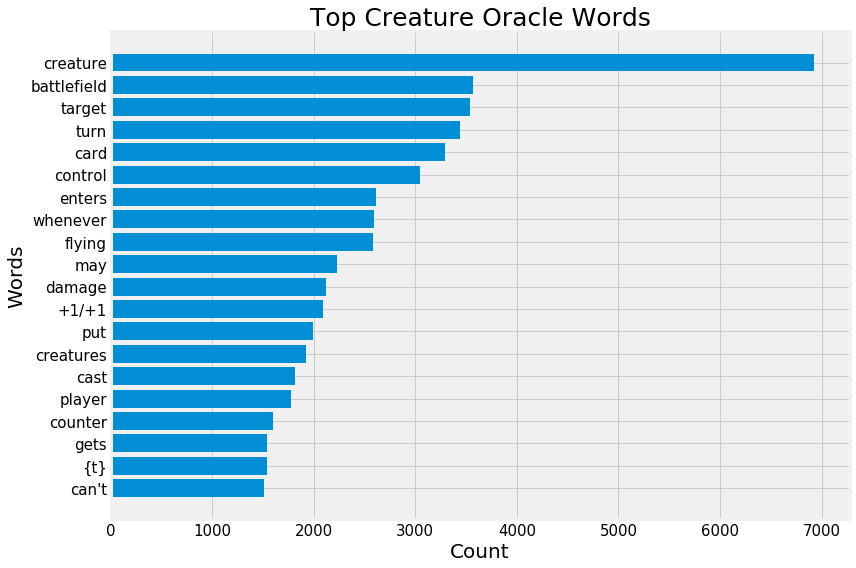

In [13]:
# make a df that is just creatures
creature_df = df.loc[(df['card_type'] == 'Creature') | (df['card_type'] == 'Artifact Creature') | 
       (df['card_type'] == 'Enchantment Creature') | (df['card_type'] == 'Land Creature') | 
       (df['card_type_back'] == 'Creature') | (df['card_type_back'] == 'Artifact Creature')]

top_words(creature_df, 'Creature', stops=stops)

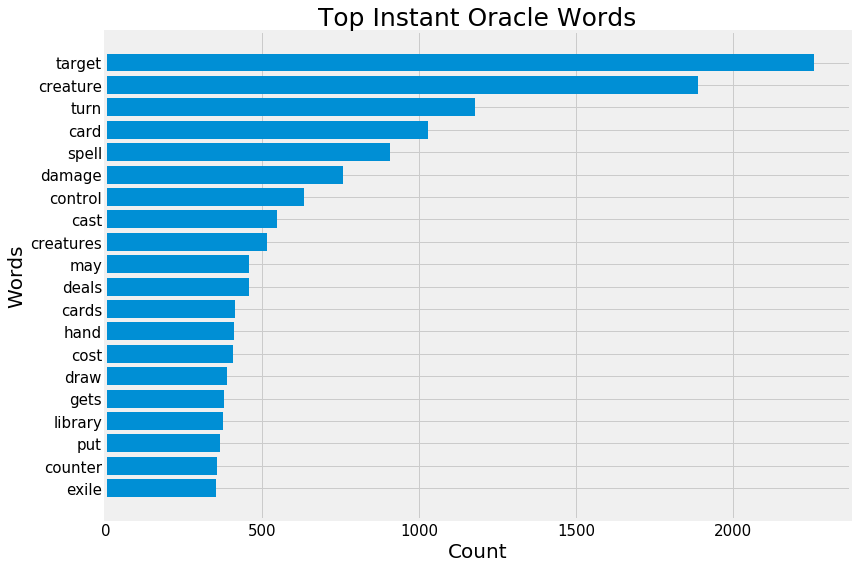

In [14]:
instant_df = df.loc[(df['card_type'] == 'Instant') | (df['card_type'] == 'Tribal Instant') | 
                   (df['card_type_back'] == 'Instant')]
top_words(instant_df, 'Instant', stops=stops)

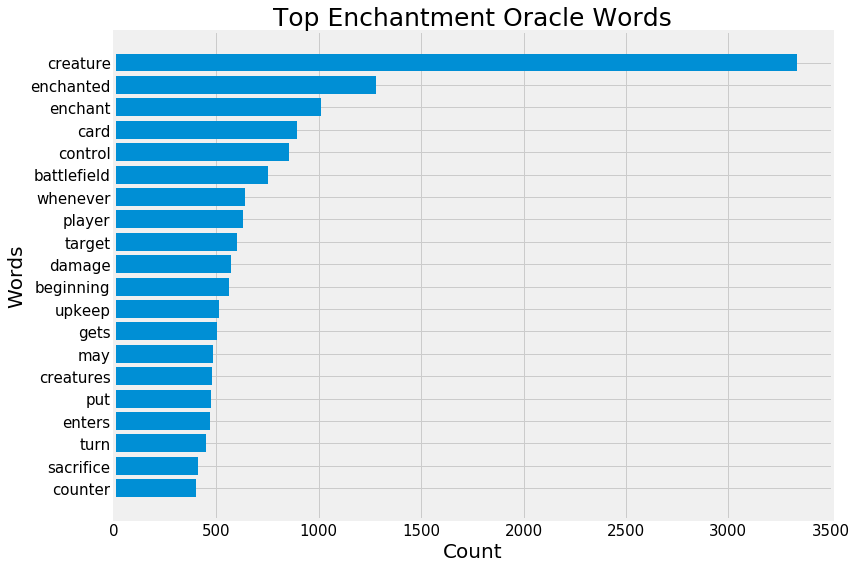

In [15]:
enchant_df = df.loc[(df['card_type'] == 'Enchantment') | (df['card_type'] == 'Enchantment Creature') | 
                    (df['card_type'] == 'Enchantment Artifact') | (df['card_type'] == 'Tribal Enchantment') | 
                    (df['card_type_back'] == 'Enchantment')]
top_words(enchant_df, 'Enchantment', stops=stops)

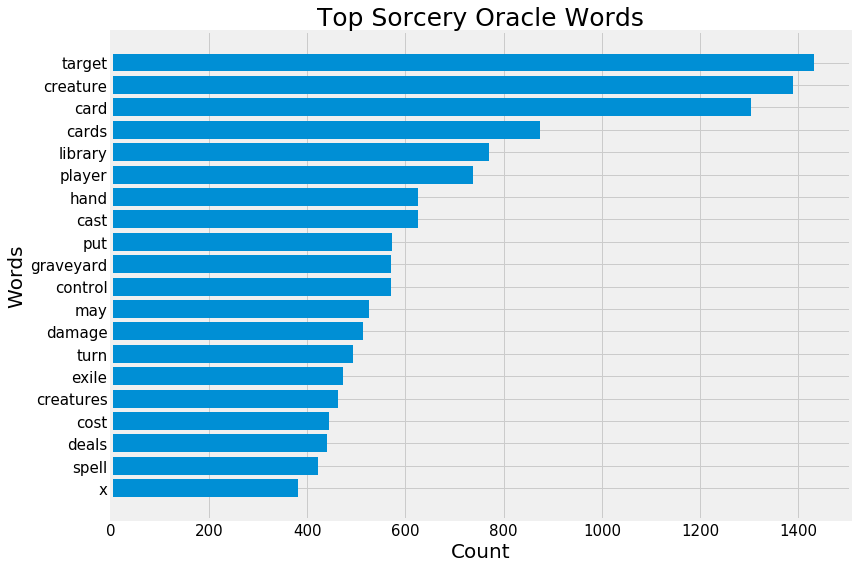

In [16]:
sorc_df = df.loc[(df['card_type'] == 'Sorcery') | (df['card_type'] == 'Tribal Sorcery') | 
                 (df['card_type_back'] == 'Sorcery')]
top_words(sorc_df, 'Sorcery', stops=stops)

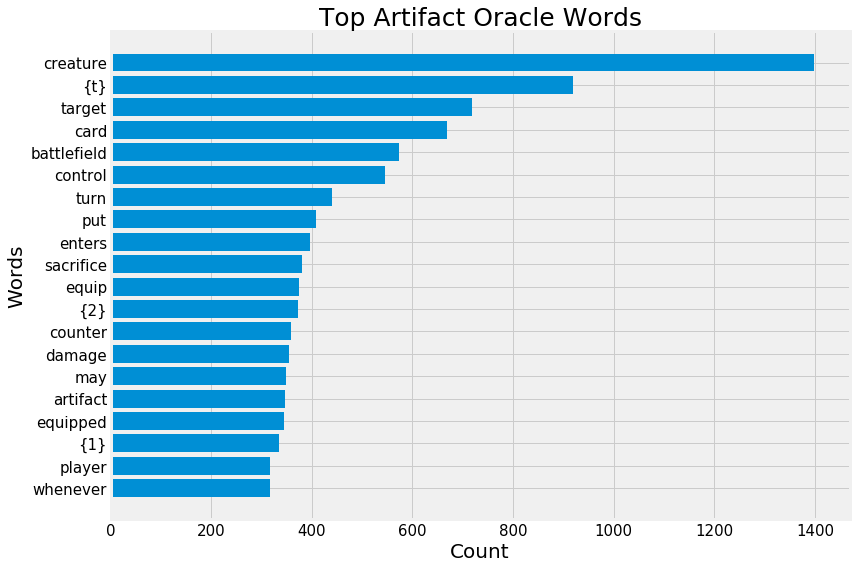

In [17]:
art_df = df.loc[(df['card_type'] == 'Artifact') | (df['card_type'] == 'Artifact Creature') | 
                    (df['card_type'] == 'Enchantment Artifact') | (df['card_type'] == 'Tribal Artifact') | 
                    (df['card_type_back'] == 'Artifact')]
top_words(art_df, 'Artifact', stops=stops)

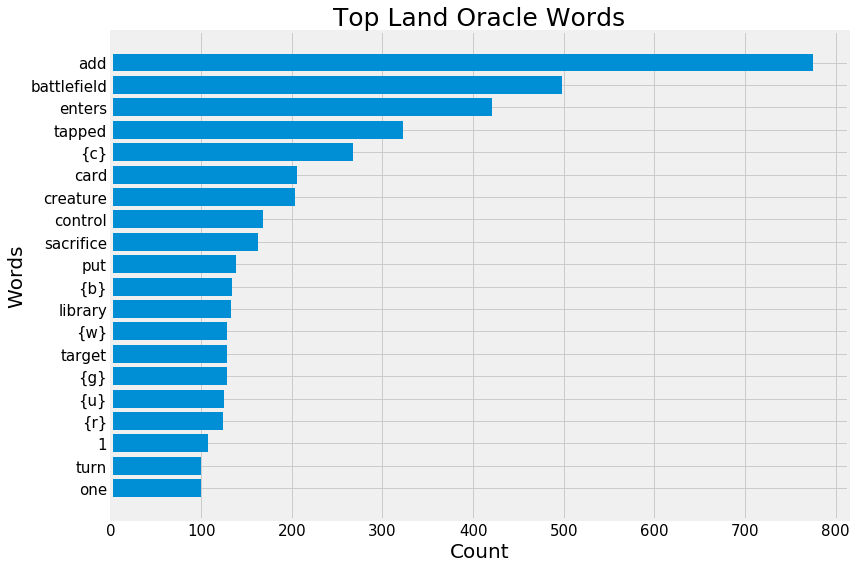

In [18]:
land_df = df.loc[(df['card_type'] == 'Land') | (df['card_type'] == 'Land Creature') | 
                 (df['card_type_back'] == 'Land')]
top_words(land_df, 'Land', stops=stops)

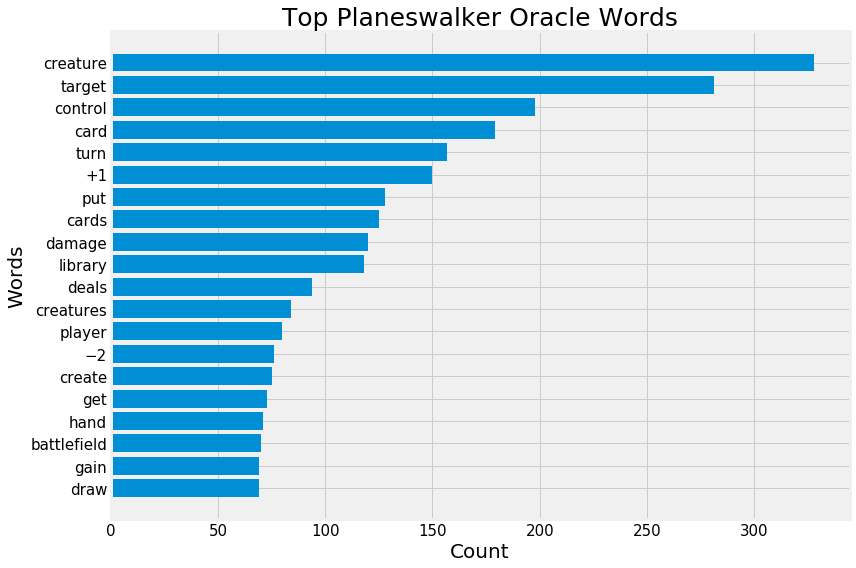

In [19]:
pw_df = df.loc[(df['card_type'] == 'Planeswalker') | (df['card_type_back'] == 'Planeswalker')]
top_words(pw_df, 'Planeswalker', stops=stops)

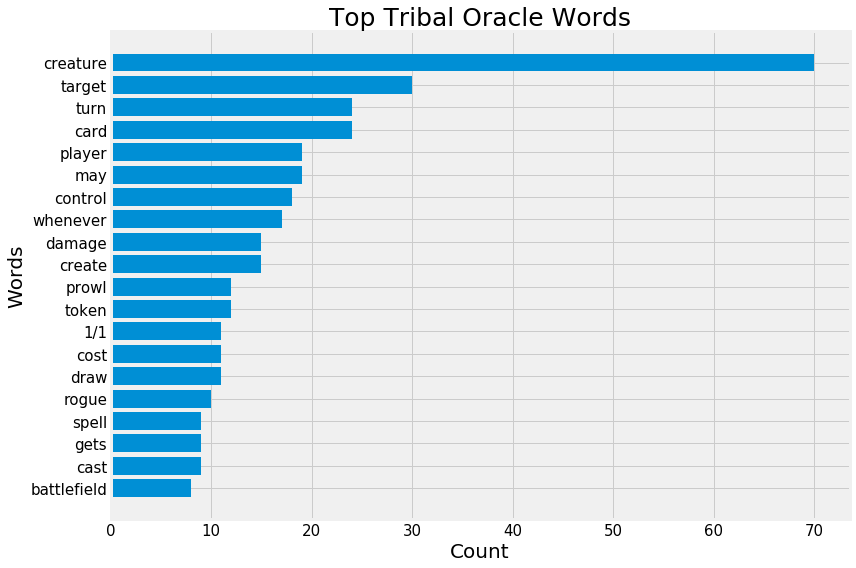

In [20]:
tribal_df = df.loc[(df['card_type'] == 'Tribal Instant') | (df['card_type'] == 'Tribal Sorcery') | 
                    (df['card_type'] == 'Tribal Artifact') | (df['card_type'] == 'Tribal Enchantment')]
top_words(tribal_df, 'Tribal', stops=stops)

___
multiple n-grams

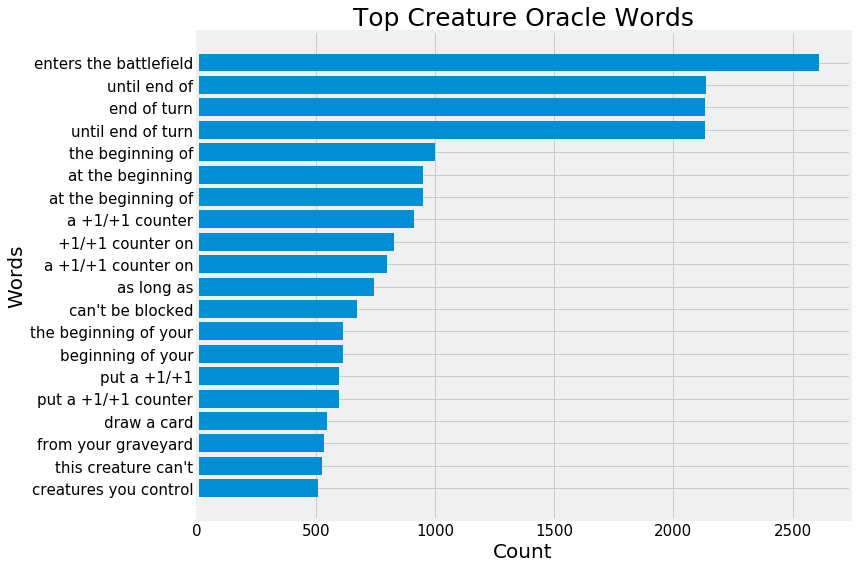

In [21]:
top_words(creature_df, 'Creature', ng=(3,4))

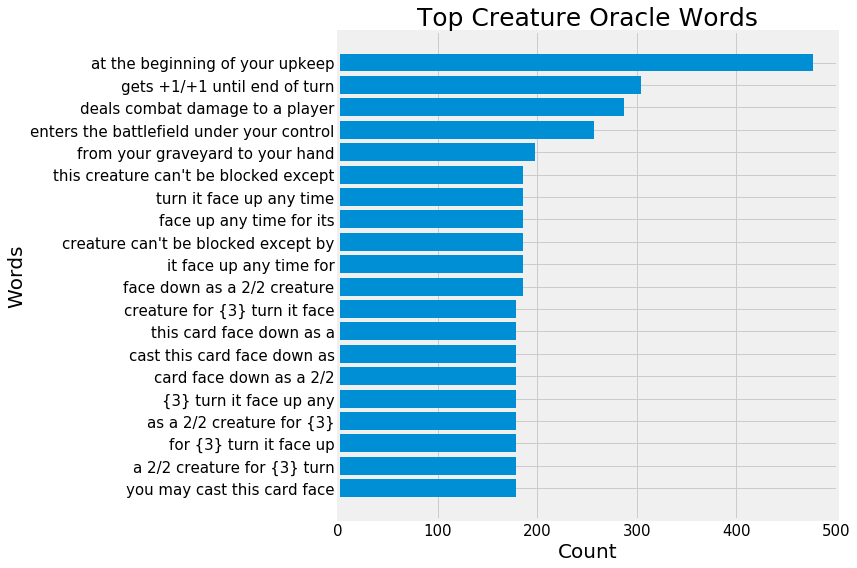

In [22]:
top_words(creature_df, 'Creature', ng=(6,6))

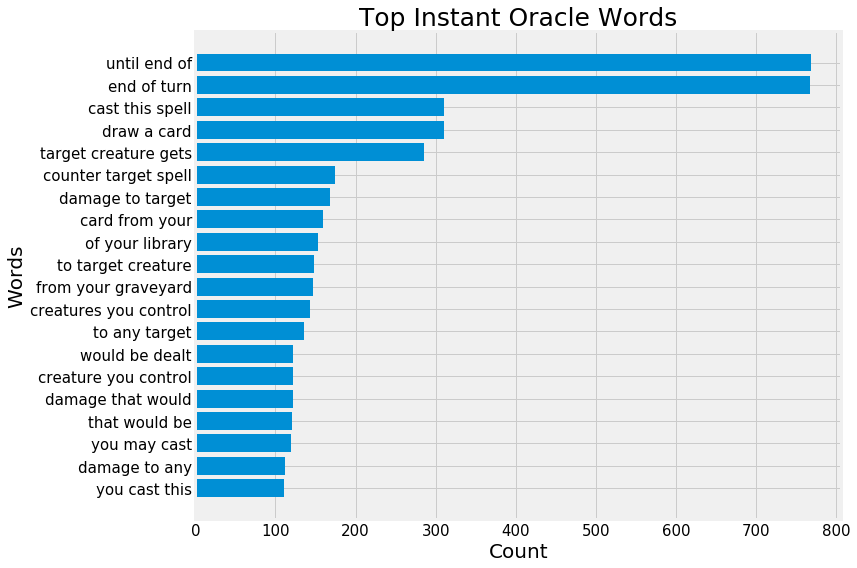

In [23]:
top_words(instant_df, 'Instant', ng=(3,3))

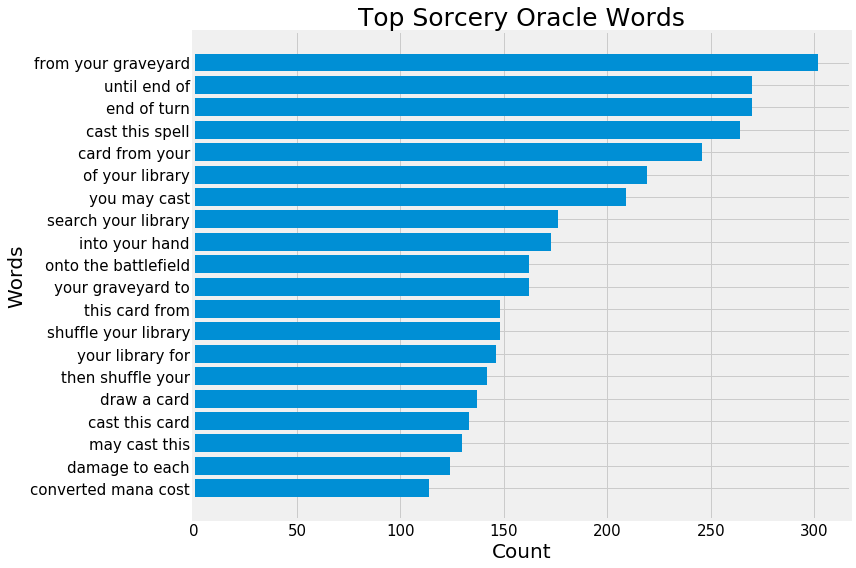

In [24]:
top_words(sorc_df, 'Sorcery', ng=(3,3))

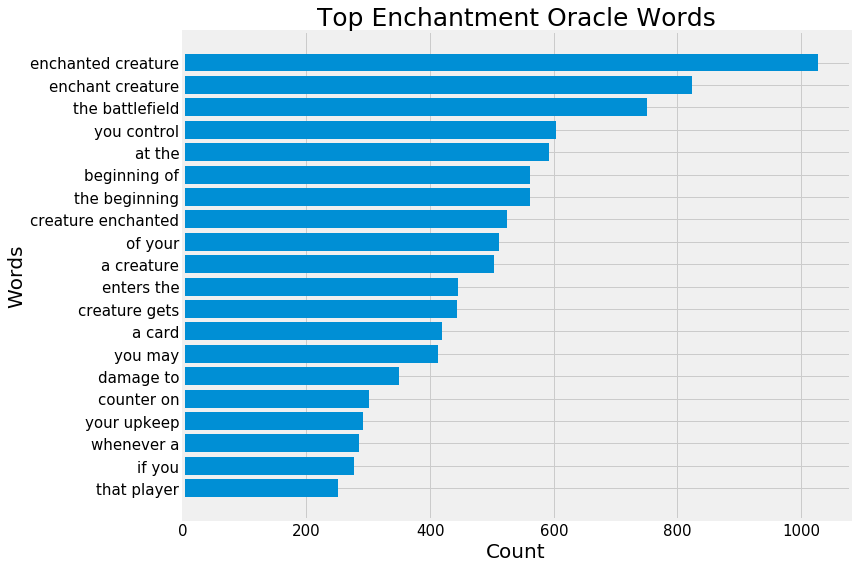

In [25]:
top_words(enchant_df, 'Enchantment', ng=(2,2))

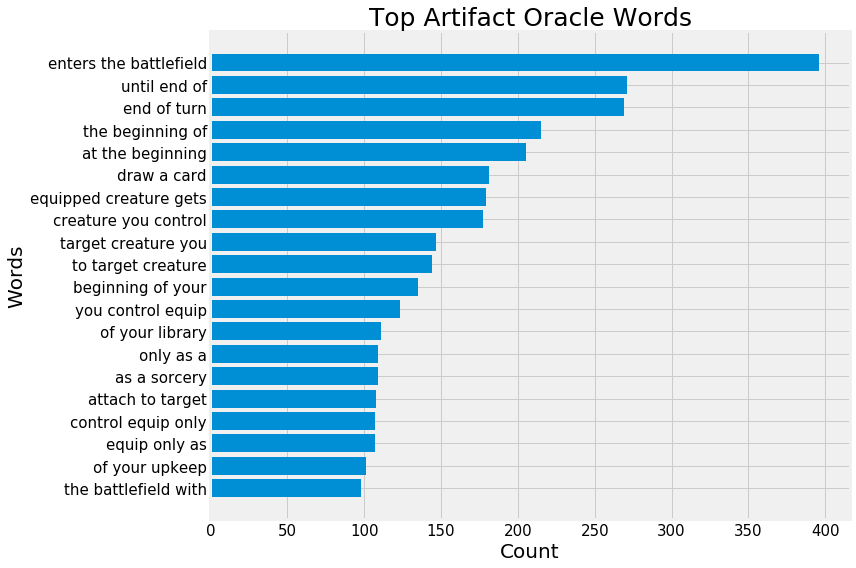

In [26]:
top_words(art_df, 'Artifact', ng=(3,3))

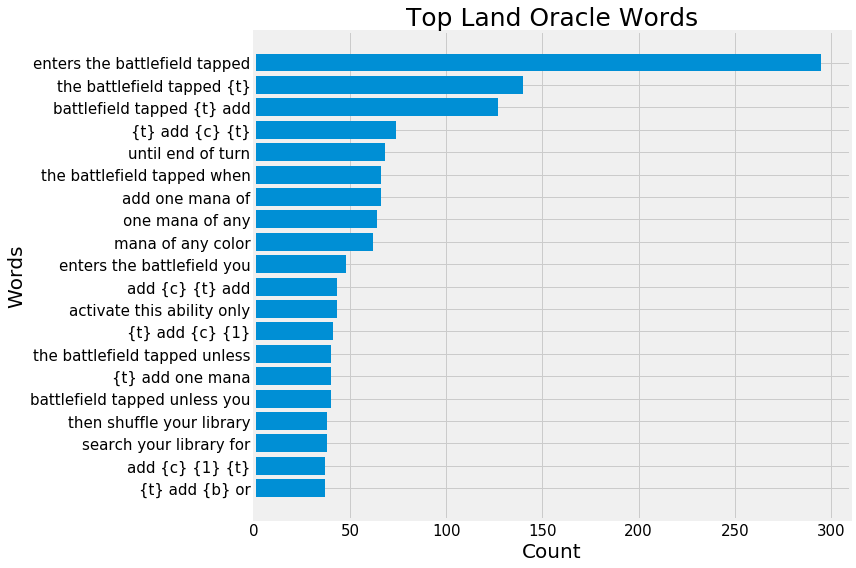

In [27]:
top_words(land_df, 'Land', ng=(4,4))

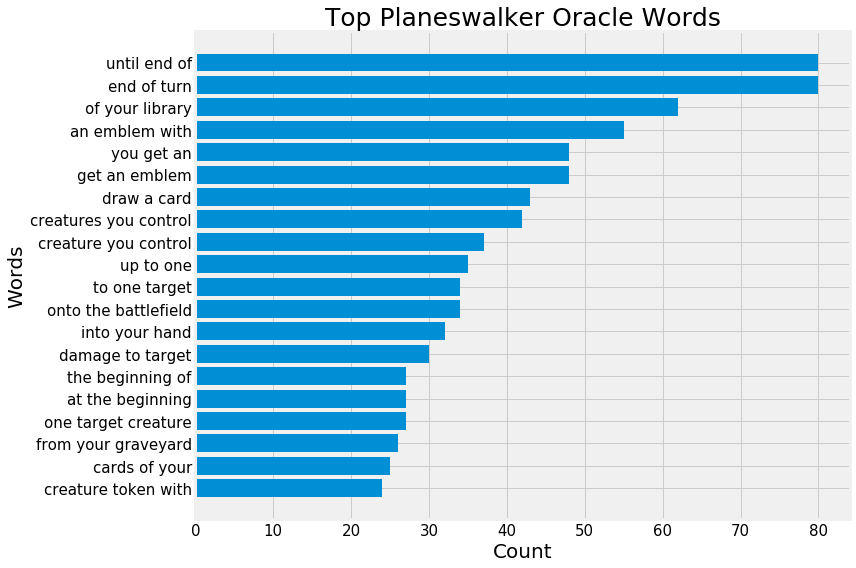

In [28]:
top_words(pw_df, 'Planeswalker', ng=(3,3))